In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from mplsoccer.pitch import Pitch, add_image
from PIL import Image
from urllib.request import urlopen
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.patheffects as path_effects
from scipy.ndimage import gaussian_filter
plt.style.use('dark_background')
%config InlineBackend.figure_format='retina'

Load data

In [2]:
df_wyscout_shots = pd.read_parquet(os.path.join('..', 'data', 'wyscout', 'shots.parquet'))
df_statsbomb_shots = pd.read_parquet(os.path.join('..', 'data', 'statsbomb', 'shots.parquet'))

Combine data

In [3]:
cols = ['x', 'y', 'goal']
df_shots = pd.concat([df_wyscout_shots[cols], df_statsbomb_shots[cols]])
print('Number of shots:', len(df_shots))

Number of shots: 64399


Subset goals

In [4]:
df_goals = df_shots[df_shots.goal].copy()
print('Number of goals:', len(df_goals))

Number of goals: 6854


Load the statsbomb logo

In [5]:
logo_alt = np.array(Image.open('SB_Regular_Alt.png'))

In [6]:
#IMAGE_URL = 'https://upload.wikimedia.org/wikipedia/en/7/75/Wyscout_Company_Logo.jpg'
#wyscout_logo = np.array(Image.open(urlopen(IMAGE_URL)))

# Basic scatter plot of goals scored and histogram

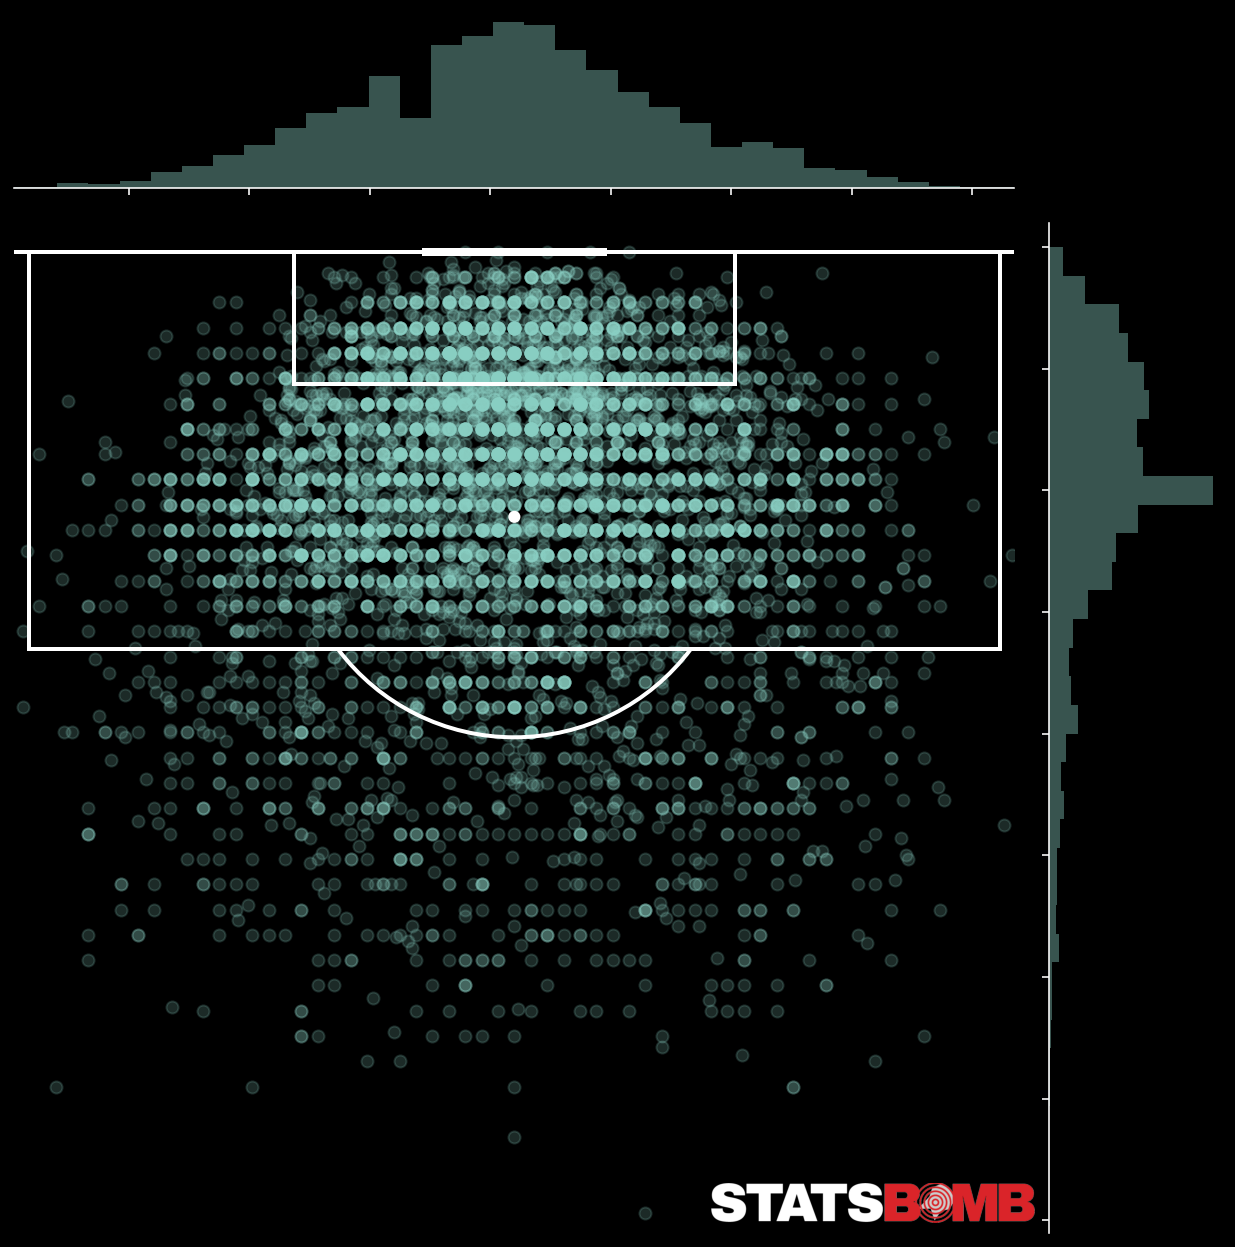

In [7]:
pitch = Pitch(figsize=(16, 20), tight_layout=False, view='half', orientation='vertical', line_zorder=2,
              pitch_type='statsperform', pad_left=-13.25, pad_right=-13.25, pad_bottom=-12, pad_top=1)
g = pitch.jointplot(df_goals.x, df_goals.y, height=9, alpha=0.2)
ax_image1 = add_image(logo_alt, g.fig, left=0.59, bottom=0.05, width=0.25, alpha=1, interpolation='hanning')
g.savefig(os.path.join('..', 'figures', '09_joint_plot_shots_example.png'), bbox_inches = 'tight', pad_inches = 0)

# Goal distribution using Kernel Density Estimation and Scott's Rule of Thumb for bandwidth

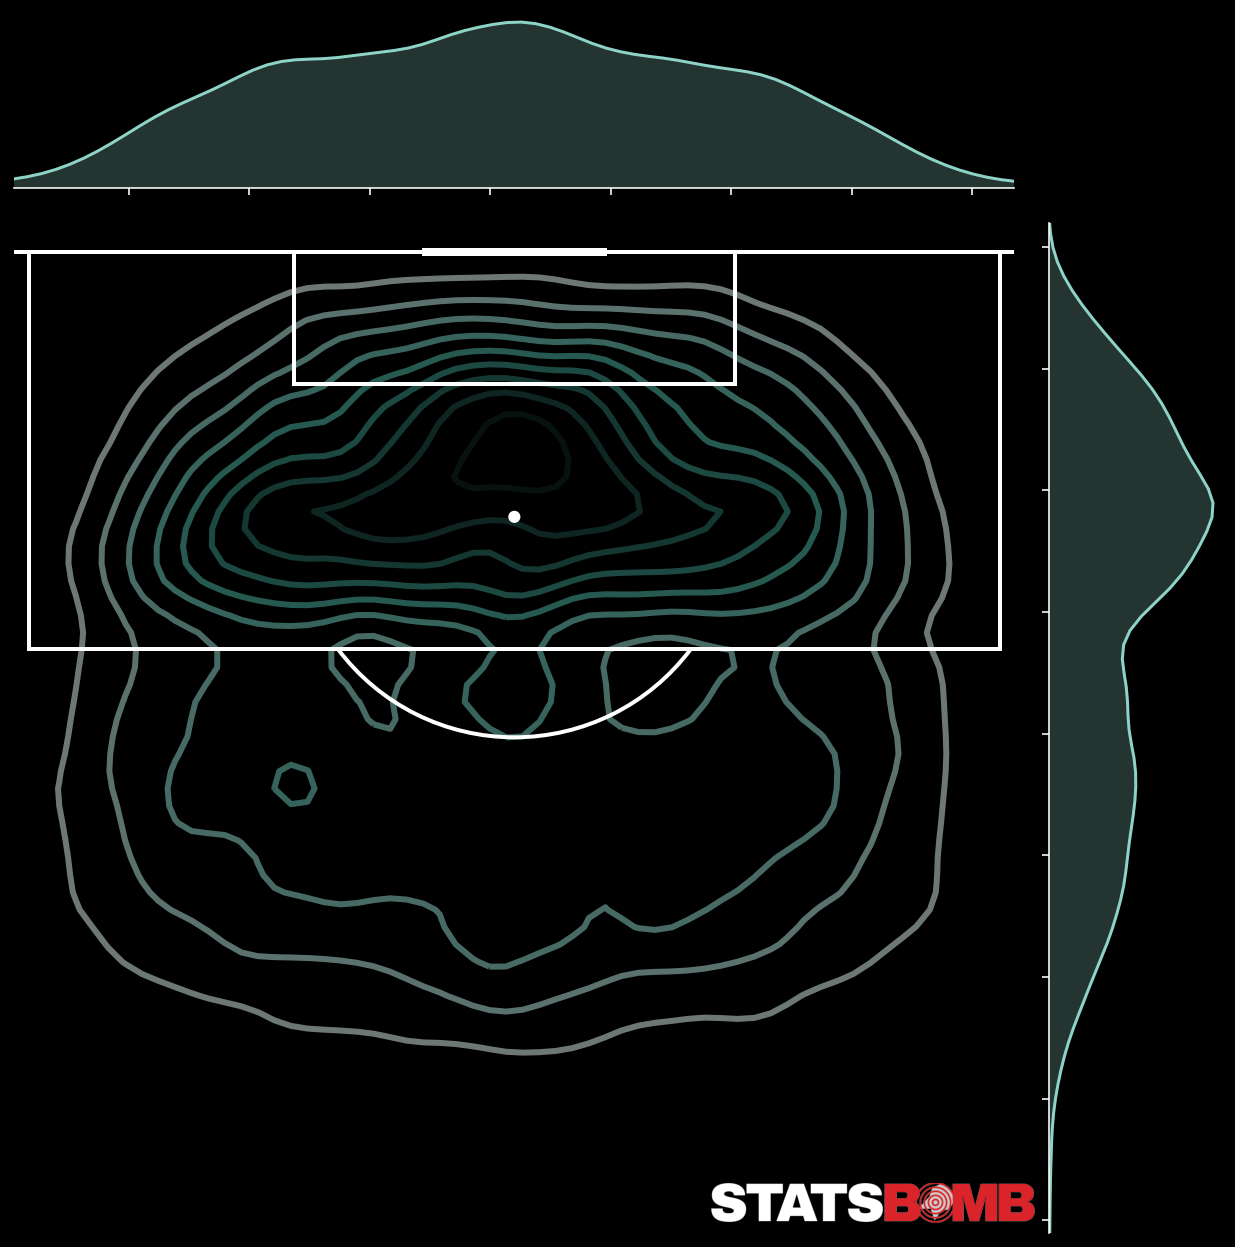

In [8]:
joint_kws = {'shade': False, 'linewidths': 3, 'kind': 'kde', 'bw': 'scott', 'kernel':'gau'}
g = pitch.jointplot(df_shots.x, df_shots.y, height=9, alpha=0.5, **joint_kws)
ax_image1 = add_image(logo_alt, g.fig, left=0.59, bottom=0.05, width=0.25, alpha=1, interpolation='hanning')
g.savefig(os.path.join('..', 'figures', '10_kde_shots_scott_example.png'), bbox_inches = 'tight', pad_inches = 0)

# Goal distribution using Kernel Density Estimation and bandwidth 5

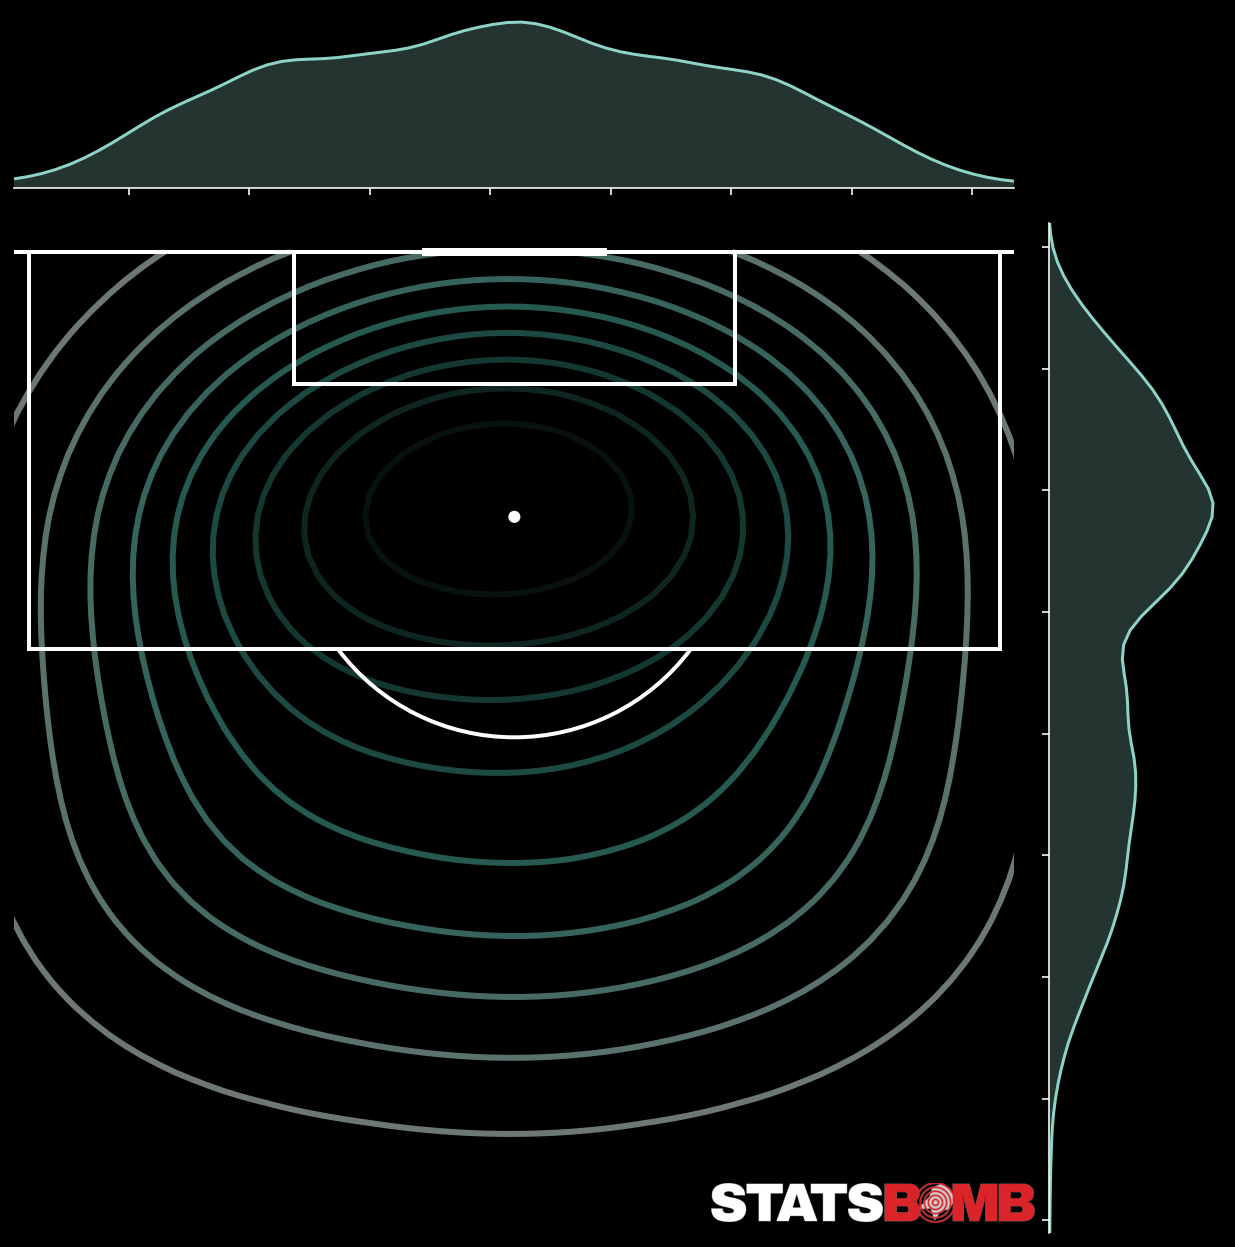

In [9]:
joint_kws = {'shade': False, 'linewidths': 3, 'kind': 'kde', 'bw': 5, 'kernel':'gau'}
g = pitch.jointplot(df_shots.x, df_shots.y, height=9, alpha=0.5, **joint_kws)
ax_image1 = add_image(logo_alt, g.fig, left=0.59, bottom=0.05, width=0.25, alpha=1, interpolation='hanning')
g.savefig(os.path.join('..', 'figures', '11_kde_shots_high_bandwidth_example.png'), bbox_inches = 'tight', pad_inches = 0)

# Fitting a cross-validated Kernel Density estimator

In [10]:
df_shots.reset_index(drop=True, inplace=True)

In [11]:
X = df_shots[['x', 'y']]
y = df_shots.goal

In [12]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(df_shots[['x', 'y']], df_shots.goal)

10

Recreate the same splits for the goals as the shots

In [26]:
df_shots['goal_number'] = df_shots.goal.cumsum() - 1
goals_cv = []
shots_cv = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    split_train_shots = X.iloc[train_index]
    split_test_shots = X.iloc[test_index]
    split_train_y = y.iloc[train_index]
    split_test_y = y.iloc[test_index]
    split_train_goals = split_train_shots[split_train_y]
    split_test_goals = split_test_shots[split_test_y]
    goals_train_idx = split_train_goals.index.tolist()
    goals_test_idx = split_test_goals.index.tolist()
    goals_train_idx = df_shots.iloc[goals_train_idx].goal_number.tolist()
    goals_test_idx = df_shots.iloc[goals_test_idx].goal_number.tolist()
    goals_cv.append((goals_train_idx, goals_test_idx))
    shots_cv.append((train_index, test_index))
df_goals.reset_index(drop=True, inplace=True)

In [22]:
param_grid = {'bandwidth': np.linspace(1., 2., 100)}
grid_goals = GridSearchCV(KernelDensity(kernel='gaussian'), param_grid=param_grid , cv=goals_cv, n_jobs=-1)
grid_goals.fit(df_goals[['x', 'y']])

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 30, 31, ...],
                  [23, 27, 46, 48, 52, 53, 71, 75, 88, 91, 99, 110, 135, 144,
                   159, 163, 179, 184, 206, 211, 240, 248, 255, 269, 275, 276,
                   292, 335, 347, 353, ...]),
                 ([1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                   21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, ...],
                  [0, 3, 4, 5, 65, 77, 79, 96, 113, 114, 125, 127, 13...
       1.65656566, 1.66666667, 1.67676768, 1.68686869, 1.6969697 ,
       1.70707071, 1.71717172, 1.72727273, 1.73737374, 1.74747475,
       1.75757576, 1.76767677, 1.77777778, 1.78787879, 1.7979798 ,
       1.80808081, 1.81818182, 1.82828283, 1.83838384, 1.84848485,
       1.85858586, 1.86868687, 1.87878788, 1.88888889, 1.8989899 ,
       1.90909091, 1.91919192, 1.92929293, 1.93939394, 1.94949495,
       1.9

In [66]:
print(grid_goals.best_estimator_)

KernelDensity(bandwidth=1.797979797979798)


In [27]:
grid_shots = GridSearchCV(KernelDensity(kernel='gaussian'), param_grid=param_grid , cv=shots_cv, n_jobs=-1)
grid_shots.fit(df_shots[['x', 'y']])
print(grid_shots.best_estimator_)

KernelDensity(bandwidth=1.0808080808080809)


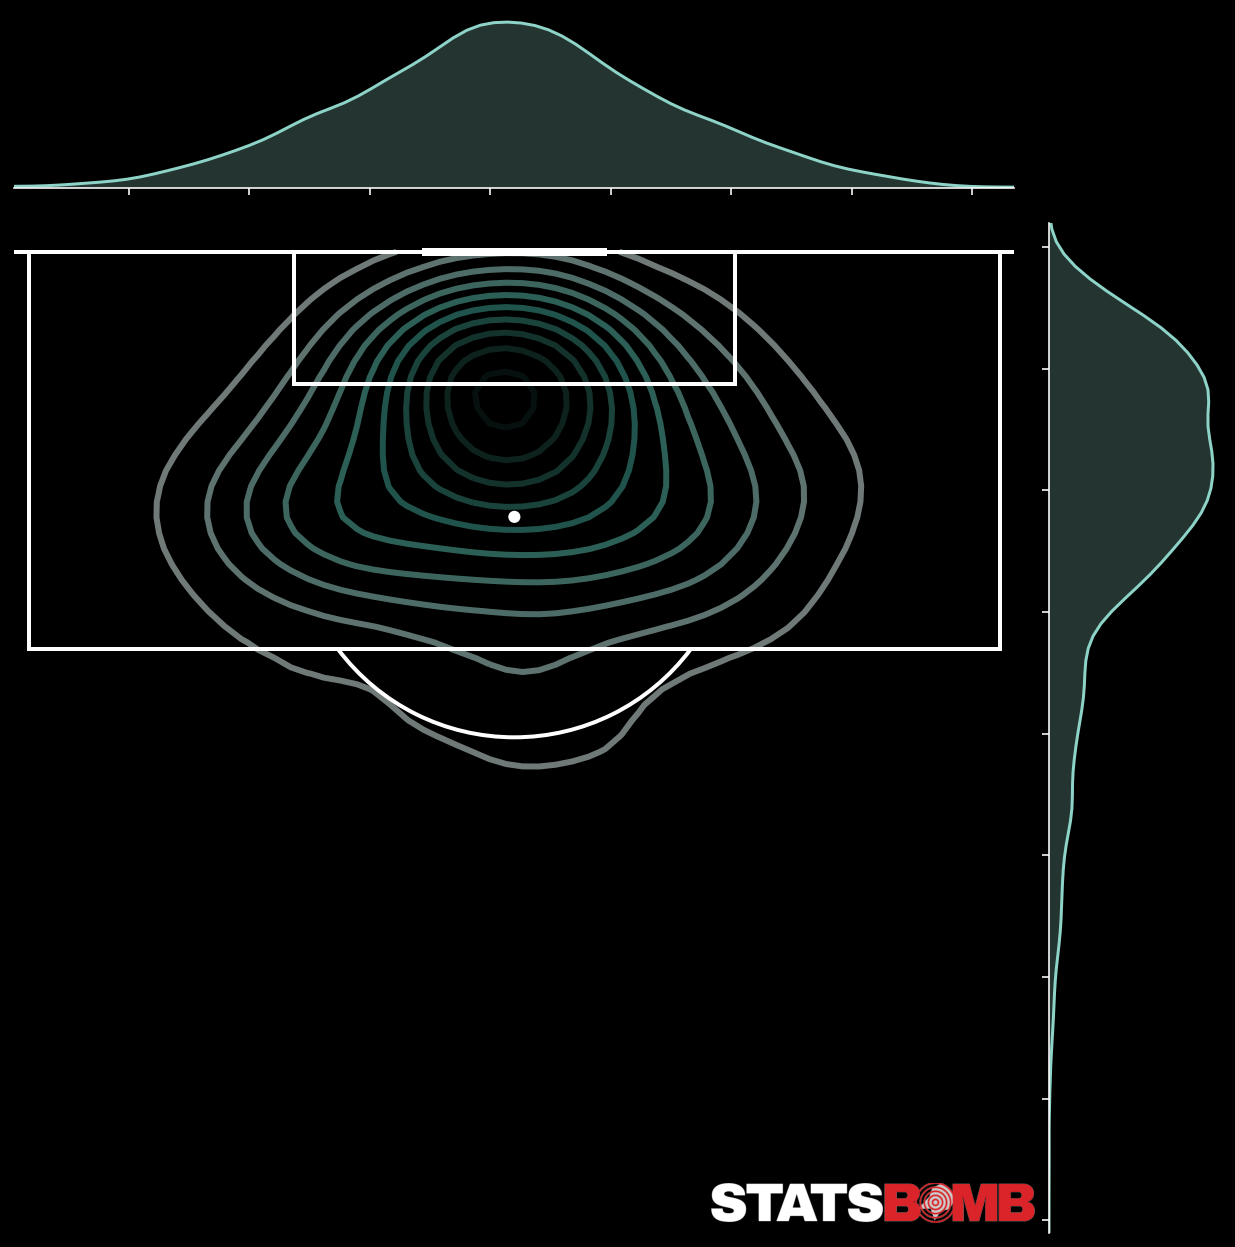

In [10]:
joint_kws = {'shade': False, 'linewidths': 3, 'kind': 'kde', 
             'bw': 1.797979797979798, 'kernel':'gau'}
g = pitch.jointplot(df_goals.x, df_goals.y, height=9, alpha=0.5, **joint_kws)
ax_image1 = add_image(logo_alt, g.fig, left=0.59, bottom=0.05, width=0.25, alpha=1, interpolation='hanning')
g.savefig(os.path.join('..', 'figures', 'kde_optimised_bw_goals.png'), bbox_inches = 'tight', pad_inches = 0)

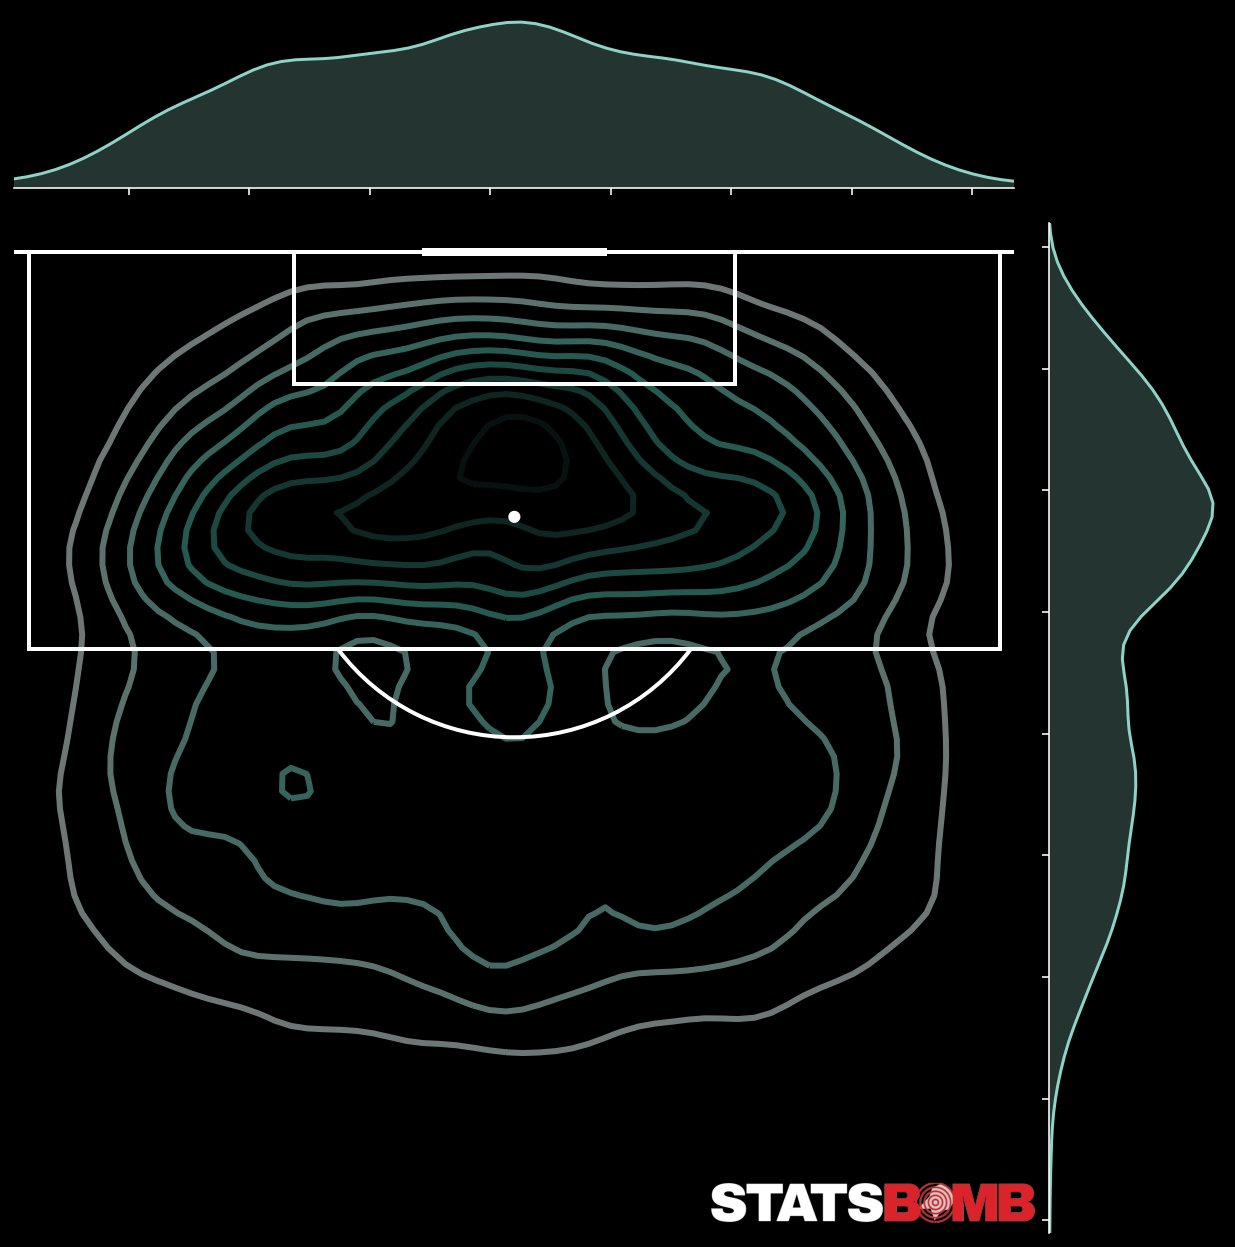

In [11]:
joint_kws = {'shade': False, 'linewidths': 3, 'kind': 'kde',
             'bw': 1.0808080808080809, 'kernel':'gau'}
g = pitch.jointplot(df_shots.x, df_shots.y, height=9, alpha=0.5, **joint_kws)
ax_image1 = add_image(logo_alt, g.fig, left=0.59, bottom=0.05, width=0.25, alpha=1, interpolation='hanning')
g.savefig(os.path.join('..', 'figures', 'kde_optimised_bw_shots.png'), bbox_inches = 'tight', pad_inches = 0)

# Plot both on same pitch

In [12]:
kernel_middle = (1.797979797979798 + 1.0808080808080809)/2

In [13]:
model_goals = KernelDensity(kernel='gaussian', bandwidth=kernel_middle)
model_shots = KernelDensity(kernel='gaussian', bandwidth=kernel_middle)

In [14]:
model_goals.fit(df_goals[['x', 'y']])
model_shots.fit(df_shots[['x', 'y']])

KernelDensity(bandwidth=1.4393939393939394)

In [15]:
x_grid = np.arange(0, 105.1, 0.25)
y_grid = np.arange(0, 68.1, 0.25)
X, Y = np.meshgrid(x_grid, y_grid)
sample = np.vstack([X.ravel(), Y.ravel()]).T

In [16]:
shot_scores = np.exp(model_shots.score_samples(sample))
goal_scores = np.exp(model_goals.score_samples(sample))

In [17]:
shot_scores = shot_scores.reshape(X.shape)
goal_scores = goal_scores.reshape(X.shape)

In [18]:
n_shots = len(df_shots)
n_goals = len(df_goals)

In [19]:
goal_scores.shape

(273, 421)

In [20]:
shot_scores.shape

(273, 421)

In [21]:
n_goals

6854

In [22]:
n_shots

64399

In [23]:
prob_scoring = ((goal_scores/shot_scores) * (n_goals / n_shots))

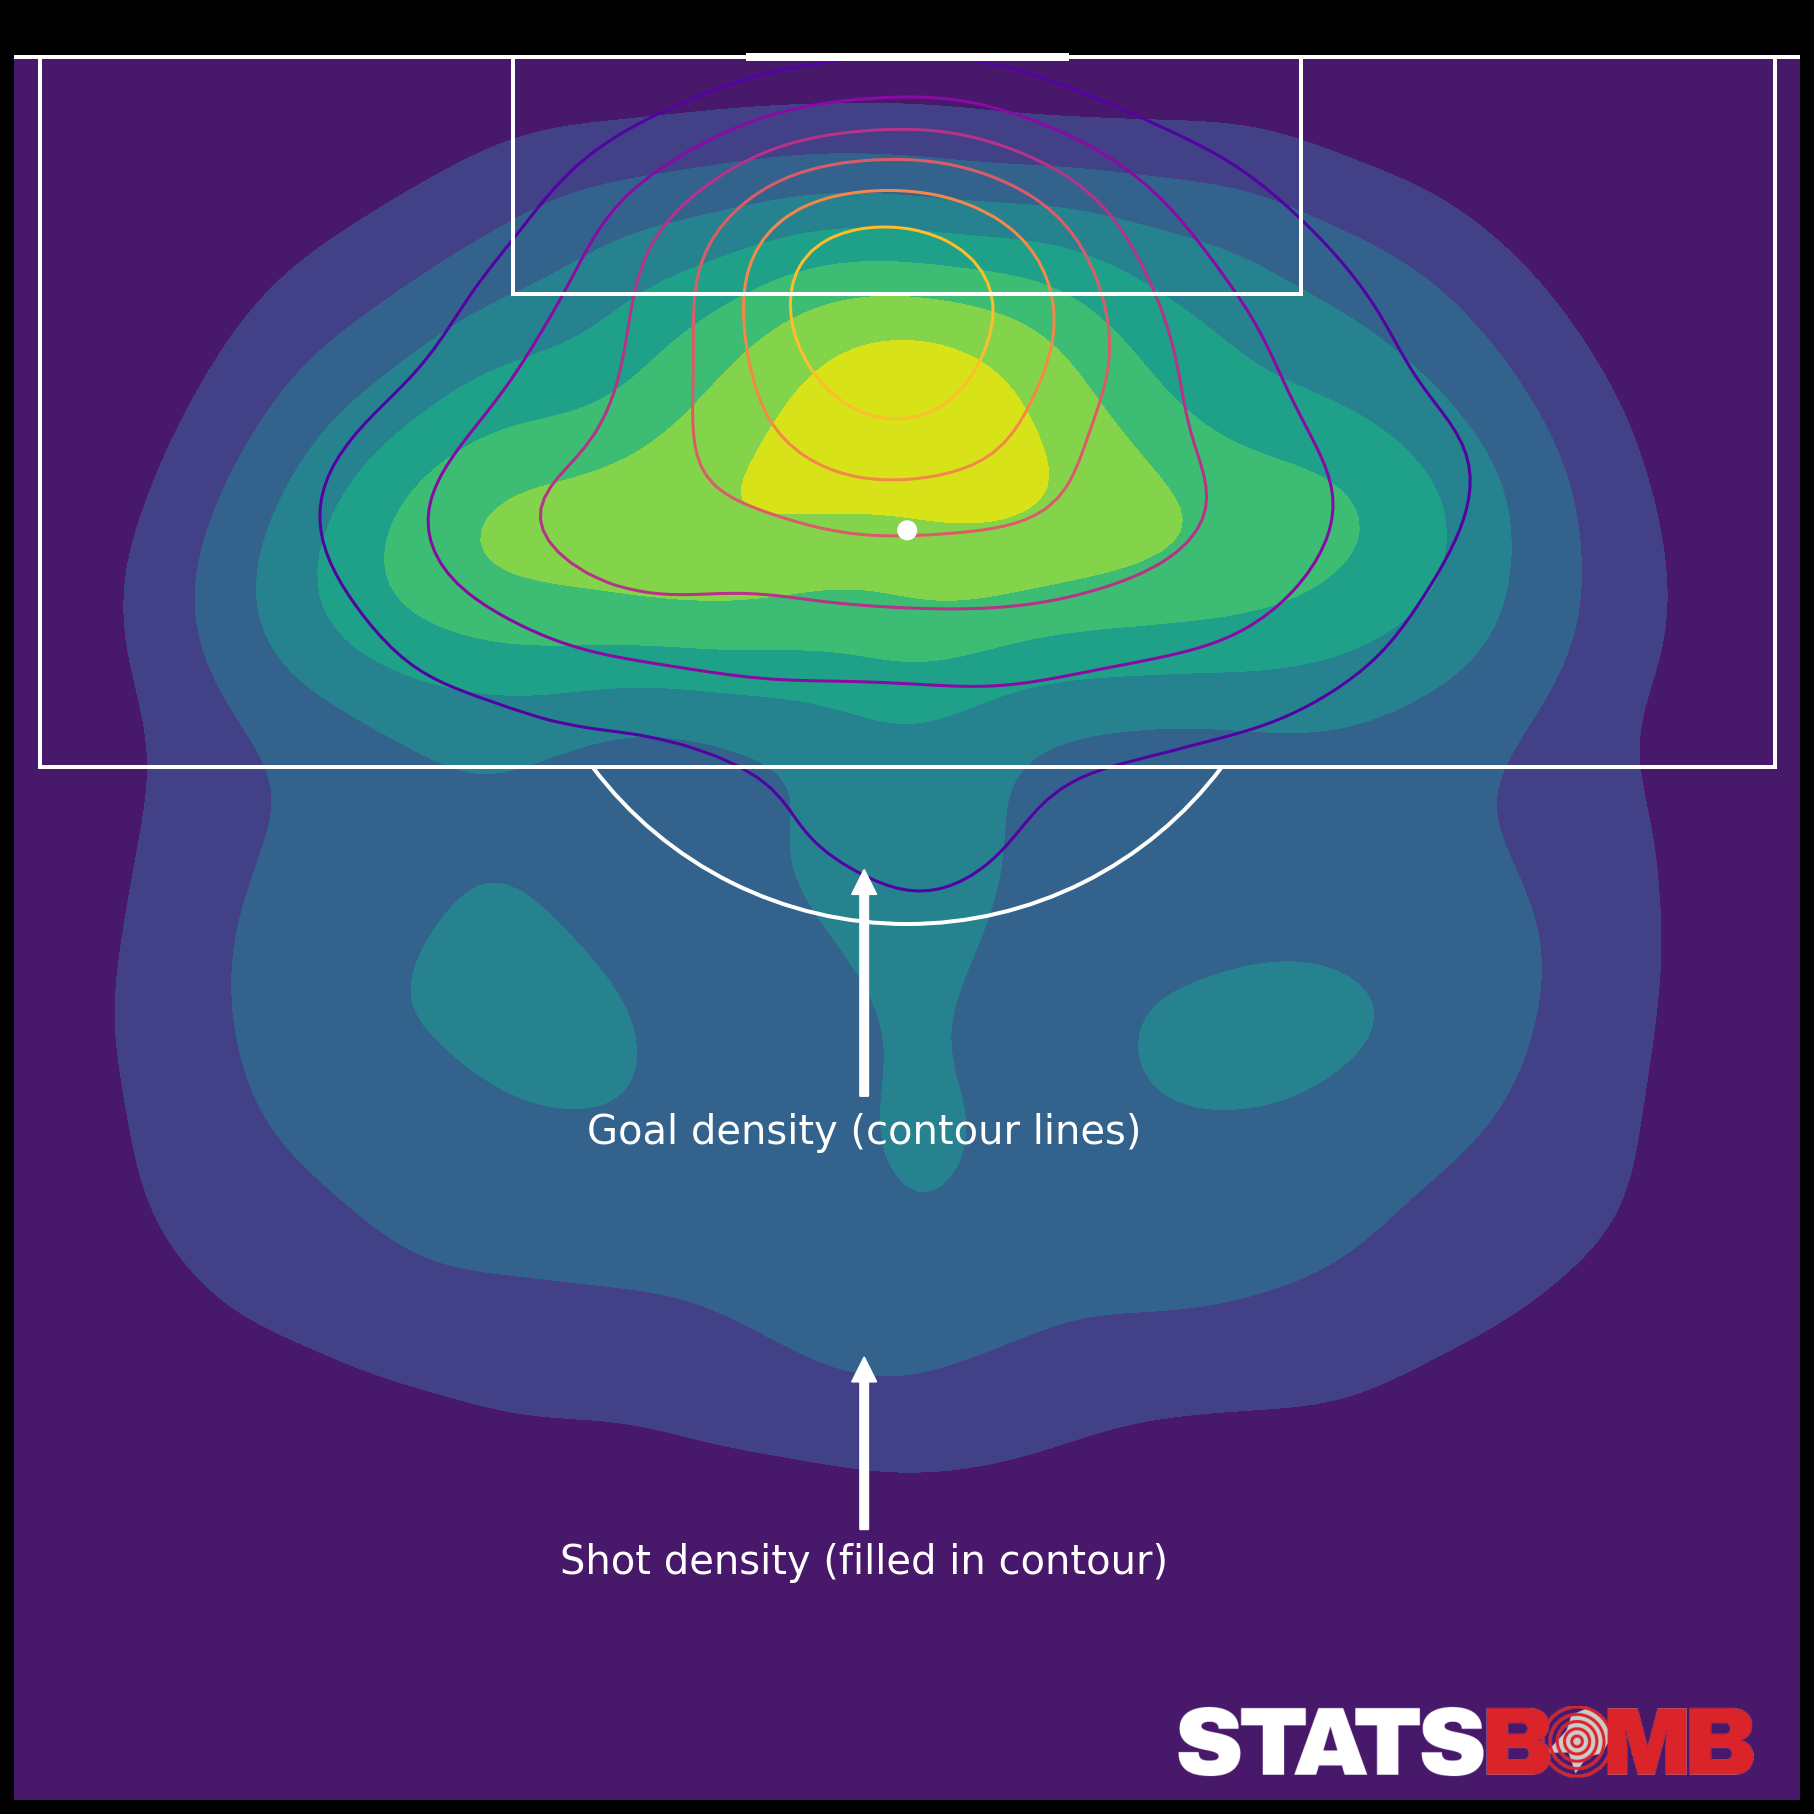

In [24]:
pitch = Pitch(figsize=(16, 20), tight_layout=False, view='half', orientation='vertical', line_zorder=2,
              pitch_type='statsperform', pad_left=-13.25, pad_right=-13.25, pad_bottom=-12, pad_top=1)
fig, ax = pitch.draw()
contour1 = ax.contourf(Y, X, shot_scores, cmap='viridis', zorder=2, alpha=1)
contour2 = ax.contour(Y, X, goal_scores, cmap='plasma', zorder=2, alpha=1)
pitch.annotate('Shot density (filled in contour)', (75, 35), (70, 35), arrowprops=dict(facecolor='white', shrink=0.05),
               fontsize=20, va='center', ha='center', ax=ax)
pitch.annotate('Goal density (contour lines)', (86.4, 35), (80, 35), arrowprops=dict(facecolor='white', shrink=0.05),
               fontsize=20, va='center', ha='center', ax=ax)
ax_image1 = add_image(logo_alt, fig, left=0.63, bottom=0.2, width=0.25, alpha=1, interpolation='hanning')
fig.savefig(os.path.join('..', 'figures', '29_kde_shot_and_goal.png'), bbox_inches = 'tight', pad_inches = 0)

In [25]:
prob_scoring = prob_scoring * 100

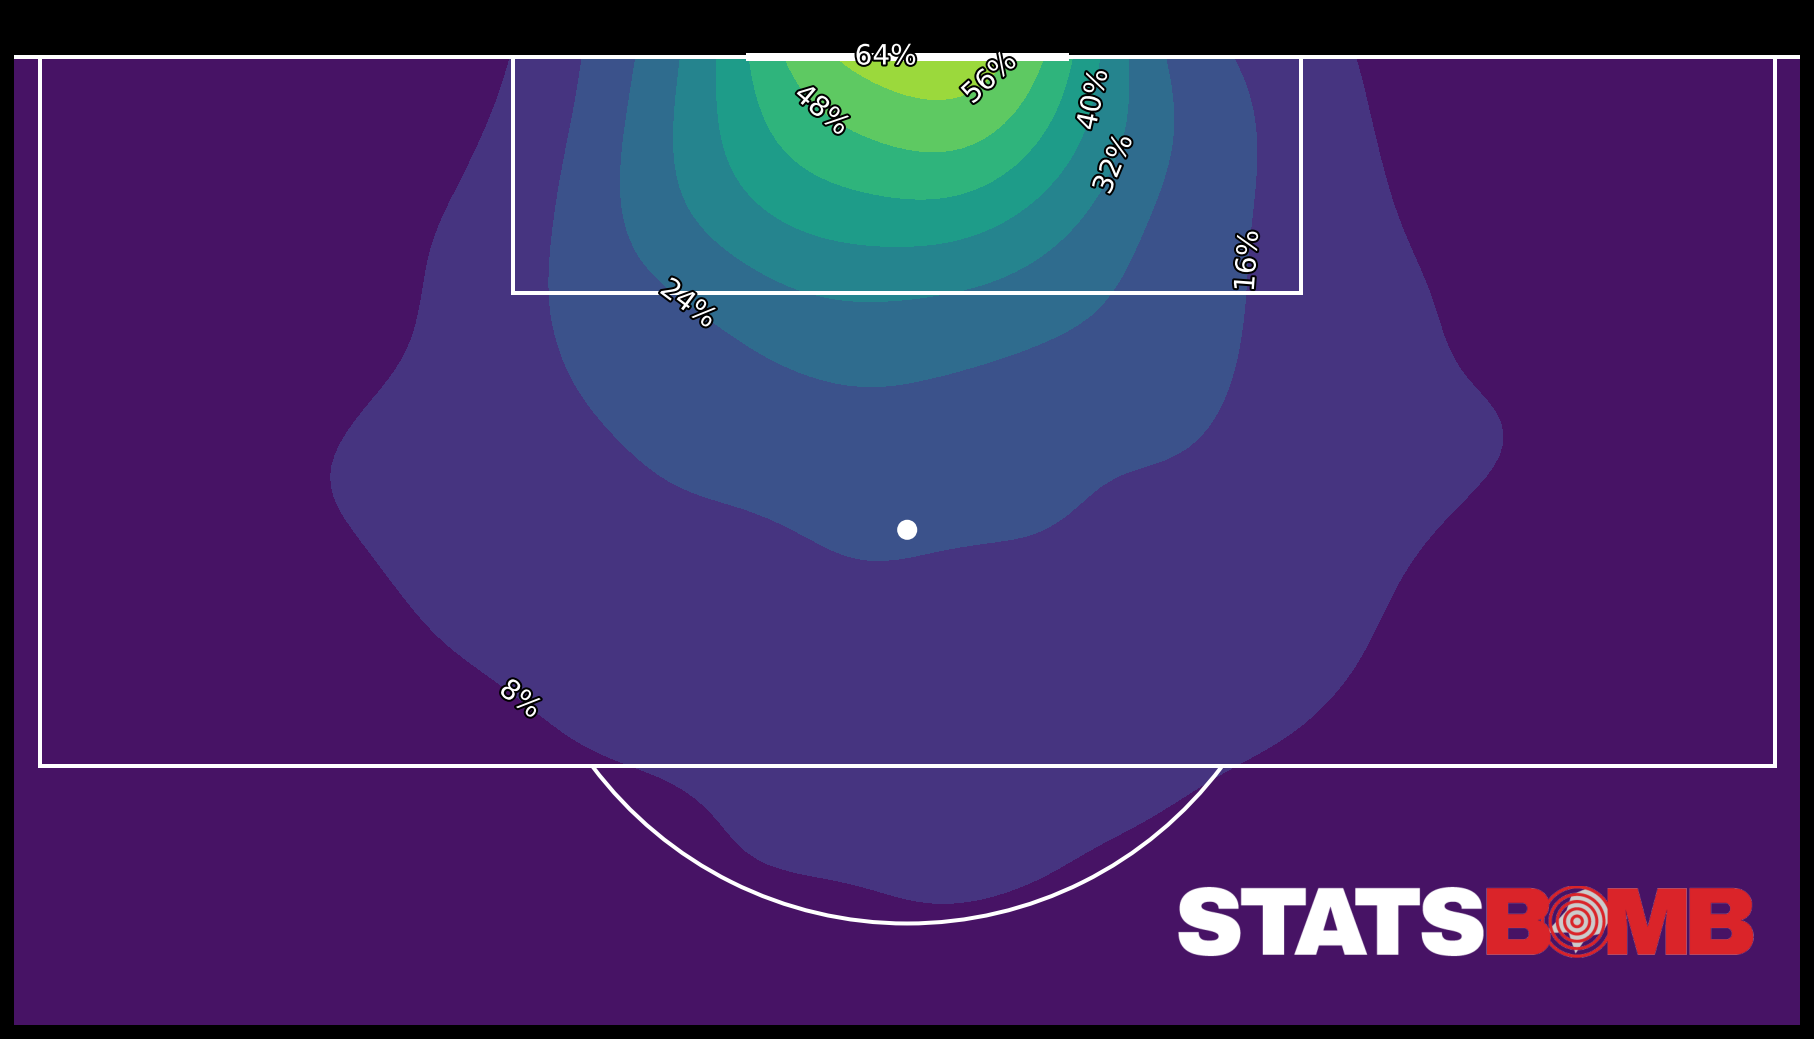

In [26]:
pitch = Pitch(figsize=(16, 20), tight_layout=False, view='half', orientation='vertical', line_zorder=2,
              pitch_type='statsperform', pad_left=-13.25, pad_right=-13.25, pad_bottom=-30, pad_top=1)
fig, ax = pitch.draw()
ax_image1 = add_image(logo_alt, fig, left=0.63, bottom=0.35, width=0.25, alpha=1, interpolation='hanning')
contour1 = ax.contourf(Y, X, prob_scoring, cmap='viridis', levels=9, zorder=2, alpha=1)
label = ax.clabel(contour1, colors='white', fontsize=14, fmt='%d%%', use_clabeltext=True, inline=True)
for l in label:
    l.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

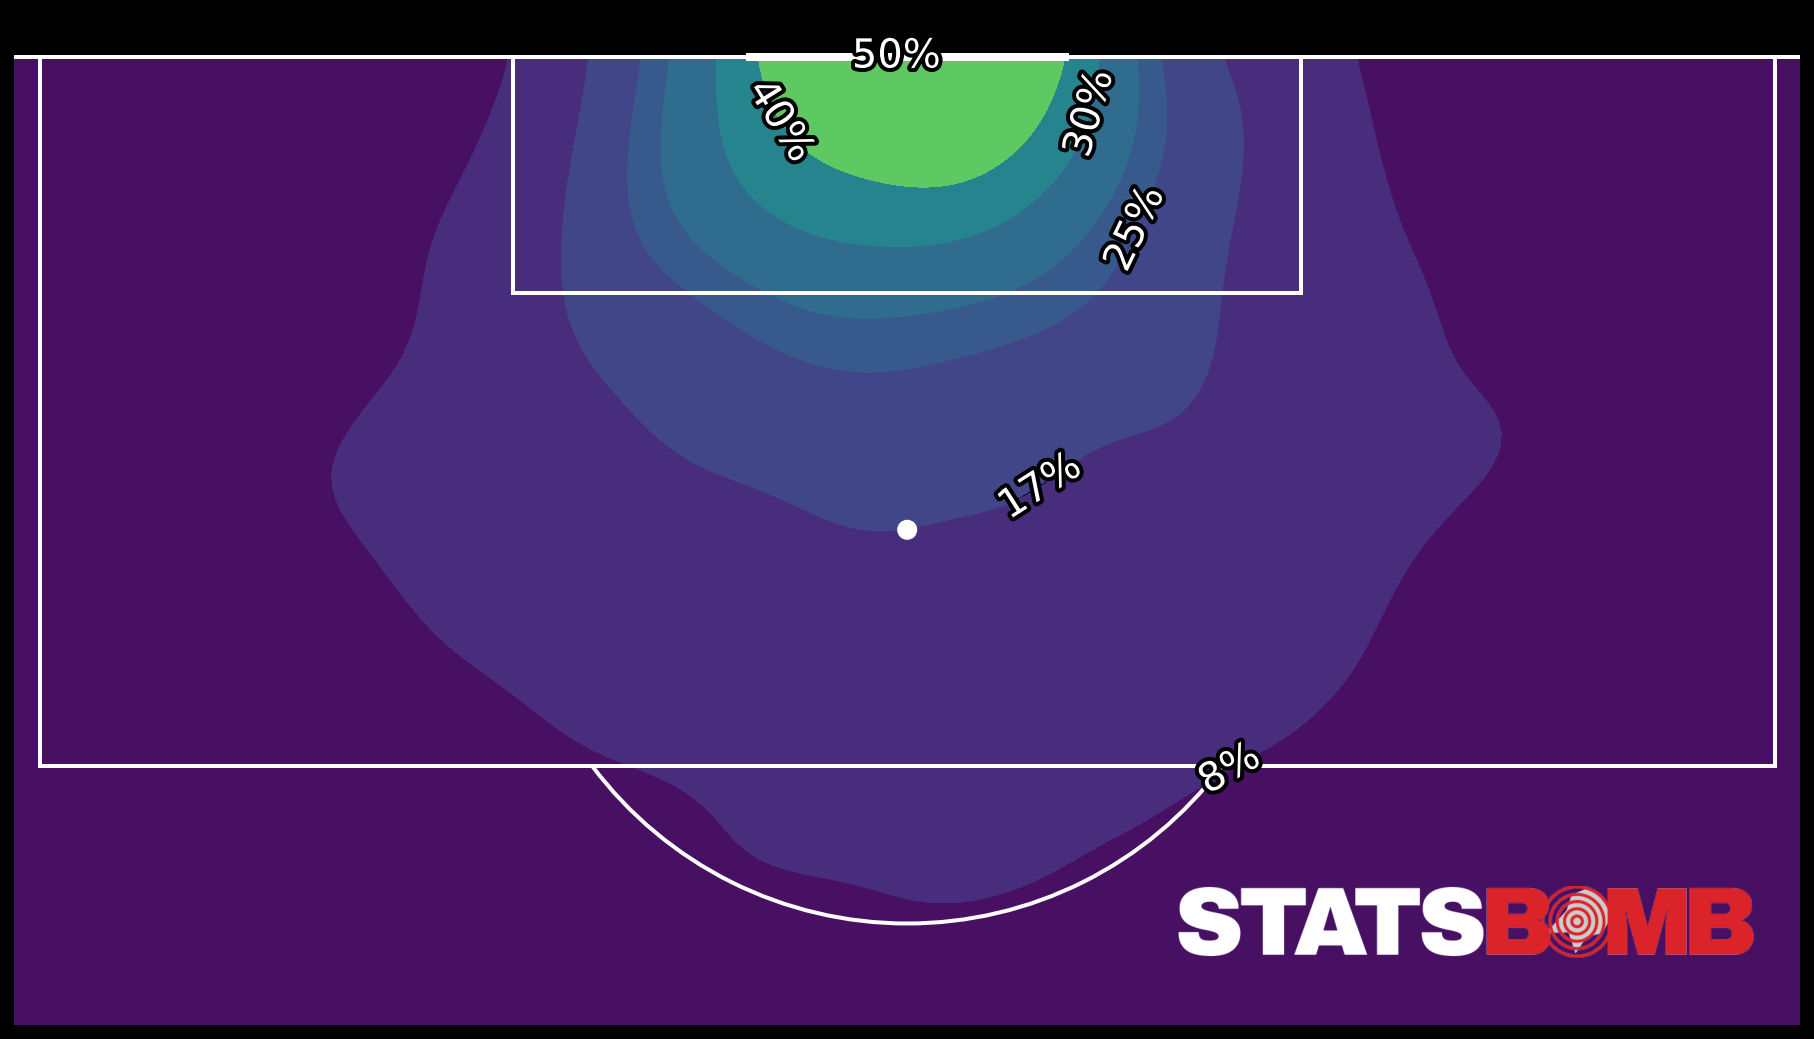

In [27]:
pitch = Pitch(figsize=(16, 20), tight_layout=False, view='half', orientation='vertical', line_zorder=2,
              pitch_type='statsperform', pad_left=-13.25, pad_right=-13.25, pad_bottom=-30, pad_top=1)
fig, ax = pitch.draw()
ax_image1 = add_image(logo_alt, fig, left=0.63, bottom=0.35, width=0.25, alpha=1, interpolation='hanning')
levels = np.array([0, 8, 17, 25, 30, 40, 50, 100])
prob_scoring_smooth = gaussian_filter(prob_scoring, 1)
contour1 = ax.contourf(Y, X, prob_scoring_smooth, cmap='viridis', levels=levels, zorder=2, alpha=1)
label = ax.clabel(contour1, colors='white', fontsize=20, fmt='%d%%', inline=True, use_clabeltext=True,)
for l in label:
    l.set_path_effects([path_effects.Stroke(linewidth=4, foreground='black'), path_effects.Normal()])
fig.savefig(os.path.join('..', 'figures', '30_kde_estimated_probability_of_scoring.png'),
            bbox_inches = 'tight', pad_inches = 0)